<a href="https://colab.research.google.com/github/MSDS19026/MSDS19026_COVID19_DLSpring2020/blob/master/Code/covid19_classification_focal_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 5 - Part 2** 
## *Detecting Coronavirus Infections through Chest X-Ray images*

### MSDS19026

### Mount Drive

In [1]:
from google.colab import drive
drive.mount("./gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


### Load Dataset

In [2]:
!unzip "./gdrive/My Drive/Copy of A_05_Part_02_Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: A_05_Part_02_Dataset/Train/normal/52f18c9e-7262-4fcc-a6bc-78e707214886.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52f53bb5-81fb-408b-adc7-2f8ae8932b31.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52fee036-272a-455a-9714-b6ff73e28403.png  
  inflating: A_05_Part_02_Dataset/Train/normal/535c2337-e755-43ea-ab1d-6547a584776d.png  
  inflating: A_05_Part_02_Dataset/Train/normal/536ba3bf-b867-4035-b483-35e9cbda9c0f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/538d24ba-8a55-4445-b0d5-f9e5812fdd49.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bae9fc-3bb2-4684-b986-84bf7aa2e5a2.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bed796-1a7b-406b-b37c-d37facb41158.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c275e1-e692-4445-bb4f-b740d117712f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c369ae-d8f9-4e44-b212-c6e2dc6ef580.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53

### Import Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import seaborn as sn
from sklearn.metrics import multilabel_confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# User Defined Functions

In [0]:
def hot_vec(label):

  one_hot = torch.zeros(len(label), 3)
  for i in range(len(label)):
    if label[i] == 0:                #Covid-19
      one_hot[i][0]=1
      one_hot[i][1]=1
    elif label[i] == 2:              #Pneumonia
      one_hot[i][1]=1
    else:
      one_hot[i][2]=1                 # Normal

  return one_hot

In [0]:
def Model_results(model_name,loader,no_classes):

  if loader == trainloader:
    print("~*Loading Results for Training*~\n\n\n")
  elif loader == validloader:
    print("~*Loading Results for Validation*~\n\n\n")
  
  total=0
  CM = np.zeros((3,2,2))
  acc=0
  prec=0
  rec=0

  with torch.no_grad():
      for data in loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          targets = hot_vec(labels).to(device)

          outputs = model_name(images)
          sig_out = Sig(outputs.data)       # Sigmoid
          predicted=torch.round(sig_out)       #0.5 threshold
          total += labels.size(0)
          
          #Confusion Matrix
          CM += multilabel_confusion_matrix(targets.data.to('cpu'),predicted.data.to('cpu'))
          
          for i in range(len(images)):

            num=(predicted[i]*targets[i]).sum().item()
            pre_den=(predicted[i]).sum().item()
            if pre_den == 0:
              pre_den=1
            rec_den=(targets[i]).sum().item()
            den=(predicted[i].logical_or_(targets[i])).sum().item()
            acc+=num/den
            prec+=num/pre_den
            rec+=num/rec_den

           
  precision = prec/total
  recall = rec/total
  F1_score = (2*precision*recall)/(precision+recall)
  print('Precision:',precision)
  print('Recall:', recall)
  print('F1 Score:', F1_score)
  print('Accuracy of the network on the images: %f %%' % (100 * acc / total))

  print("\nConfusion Matrices\n")
  
  fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (24,5))
  sn.heatmap(CM[0],cmap="Greens", annot=True, ax = ax, fmt ='g'); 
  ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Covid-19');

  sn.heatmap(CM[1],cmap="Greens", annot=True, ax = ax1,fmt ='g'); 
  ax1.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);
  ax1.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax1.set_title('Pneumonia');

 
  sn.heatmap(CM[2],cmap="Greens", annot=True, ax = ax2,fmt ='g'); 
  ax2.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);
  ax2.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax2.set_title('Normal');
  
  plt.show()

In [0]:
def test_results(loader):

  if loader == trainloader:
    print("~*Loading Results for Training*~\n\n\n")
  elif loader == validloader:
    print("~*Loading Results for Validation*~\n\n\n")
  elif loader == testloader:
    print("~*Loading Results for Testing*~\n\n\n")
    
  prediction = torch.zeros(len(test_data), 3)
  count=0
  predicted_results=[]
  image_name=[]
  with torch.no_grad():
      for data,_ in loader:
          images = data.to(device)
          outputs = vgg16(images)
          sig_out = Sig(outputs.data)       # Sigmoid
          predicted=torch.round(sig_out)       #0.5 threshold
          for i in range(len(images)):
            sample_fname, _ = loader.dataset.samples[count]                          #Finding path for current image
            spl_word = 'A_05_Part_02_Dataset/test/Test/'
            image_name.append(sample_fname.partition(spl_word)[-1])              #Taking out only name from the path
            prediction[count]=predicted[i]                        # Storing predicted results
            count+=1
  prediction.int()
  col_2=prediction[:,0].tolist()
  col_3=prediction[:,1].tolist()
  col_4=prediction[:,2].tolist()
  print("Prediction Completed\n")
  print("Compiling .csv file for results..")
  
  
  df = pd.DataFrame({'Image Name': image_name,'Covid-19': col_2, 'Pneumonia': col_3, 'Normal': col_4})
  df.to_csv("/content/gdrive/My Drive/MS Data Science 2019-2021/Semester 2/DL/Assignment_5/VGG16_focal_results.csv")
  print("csv file saved in directory!")
  print(df)

In [0]:
def resnet_test_results(loader):

  if loader == trainloader:
    print("~*Loading Results for Training*~\n\n\n")
  elif loader == validloader:
    print("~*Loading Results for Validation*~\n\n\n")
  elif loader == testloader:
    print("~*Loading Results for Testing*~\n\n\n")
  prediction = torch.zeros(len(test_data), 3)
  count=0
  image_name=[]
  with torch.no_grad():
      for data,_ in loader:
          images = data.to(device)
          outputs = resnet18(images)
          sig_out = Sig(outputs.data)       # Sigmoid
          predicted=torch.round(sig_out)       #0.5 threshold
          for i in range(len(images)):
            sample_fname, _ = loader.dataset.samples[count]                          #Finding path for current image
            spl_word = 'A_05_Part_02_Dataset/test/Test/'
            image_name.append(sample_fname.partition(spl_word)[-1])              #Taking out only name from the path
            prediction[count]=predicted[i]                        # Storing predicted results
            count+=1
  
  prediction.int()
  col_2=prediction[:,0].tolist()
  col_3=prediction[:,1].tolist()
  col_4=prediction[:,2].tolist()
  print("Prediction Completed\n")
  print("Compiling .csv file for results..")
  
  
  df = pd.DataFrame({'Image Name': image_name,'Covid-19': col_2, 'Pneumonia': col_3, 'Normal': col_4})
  df.to_csv("/content/gdrive/My Drive/MS Data Science 2019-2021/Semester 2/DL/Assignment_5/resnet18_results.csv")
  print("csv file saved in directory!")
  print(df)

In [0]:
 def focal_loss(pred,t_label,alpha,gamma):
  
  criterion = nn.BCEWithLogitsLoss(reduction = 'none')
  bce_loss = criterion(pred,t_label)
  pt = torch.exp(-bce_loss)
  loss = alpha*((1-pt)**gamma)*bce_loss

  return torch.mean(loss)

#### Making Directory for Test Data

In [8]:
dirName = 'test'
 
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  test  Created 


In [0]:
!mv "A_05_Part_02_Dataset/Test" "test"
!mv  "test" "A_05_Part_02_Dataset"

### Loading and normalizing X-Rays

In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder('A_05_Part_02_Dataset/Train', transform=train_transforms)
valid_data = datasets.ImageFolder('A_05_Part_02_Dataset/Validation', transform=valid_transforms)
test_data = datasets.ImageFolder('A_05_Part_02_Dataset/test', transform=test_transforms)
#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers =4)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True,num_workers =4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True,num_workers =4)

In [13]:
print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


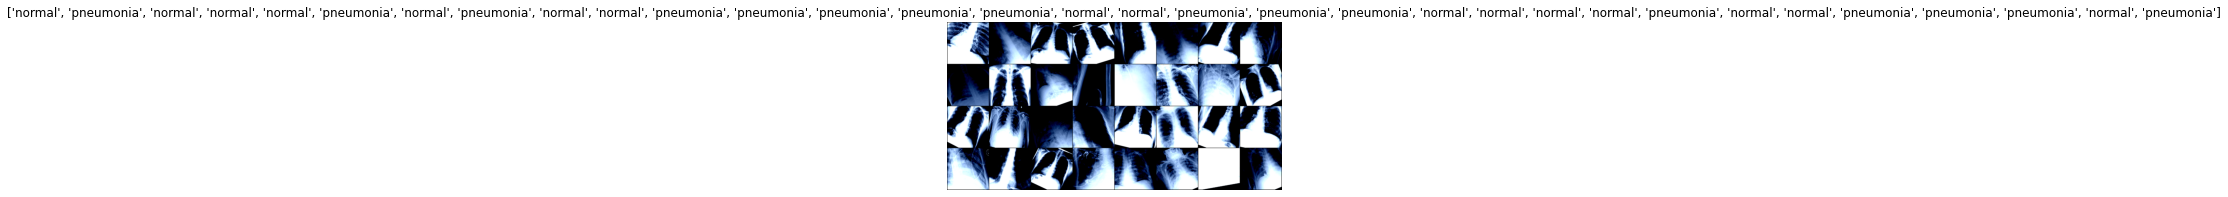

In [14]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# Task 1: VGG-16

### Load pre-trained VGG-16

In [172]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Removing FC Layers

In [173]:
num_features = vgg16.classifier[0].in_features
print(num_features)

25088


In [174]:
features = list(vgg16.classifier.children())[:0] # Remove last layer
print(features)

[]


### Adding New layers

In [175]:
features.extend([nn.Linear(num_features, 250)])
features.extend([nn.Linear(250, len(class_names))])
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Training

In [0]:
Epochs = 25
criterion = nn.BCEWithLogitsLoss()
Sig = nn.Sigmoid()
optimizer = optim.SGD(vgg16.parameters(), lr=0.004, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    acc = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = hot_vec(labels).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
  
        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, targets)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        
        sig_out = Sig(outputs.data)       # Sigmoid
        predicted=torch.round(sig_out)       #0.5 threshold
        
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    train_accuracy.append(100 * acc / len(train_data))
    train_loss.append(running_loss)
    print('Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')


    acc = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = hot_vec(labels).to(device)
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, targets)   #----> compute loss
        sig_out = Sig(outputs.data)       # Sigmoid
        predicted=torch.round(sig_out)       #0.5 threshold
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        running_loss += loss.item()
        # print statistics
        pbar.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.data))
    valid_accuracy.append(100 * acc / len(valid_data))
    valid_loss.append(running_loss)
    print('Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Train Epoch: 0 [552/6200 (12%)]	Loss: 0.357544: : 194it [02:03,  1.57it/s]


Accuracy: 82 %


Valid Epoch: 0 [380/628 (95%)]	Loss: 0.240651: : 20it [00:11,  1.80it/s]

Accuracy: 89 %



Train Epoch: 1 [552/6200 (12%)]	Loss: 0.212811: : 194it [02:04,  1.56it/s]


Accuracy: 86 %


Valid Epoch: 1 [380/628 (95%)]	Loss: 0.096489: : 20it [00:10,  1.82it/s]

Accuracy: 91 %



Train Epoch: 2 [552/6200 (12%)]	Loss: 0.409395: : 194it [02:04,  1.56it/s]


Accuracy: 88 %


Valid Epoch: 2 [380/628 (95%)]	Loss: 0.065195: : 20it [00:11,  1.80it/s]

Accuracy: 91 %



Train Epoch: 3 [552/6200 (12%)]	Loss: 0.101564: : 194it [02:04,  1.56it/s]


Accuracy: 88 %


Valid Epoch: 3 [380/628 (95%)]	Loss: 0.319263: : 20it [00:10,  1.83it/s]

Accuracy: 90 %



Train Epoch: 4 [552/6200 (12%)]	Loss: 0.556866: : 194it [02:02,  1.58it/s]


Accuracy: 89 %


Valid Epoch: 4 [380/628 (95%)]	Loss: 0.059080: : 20it [00:10,  1.84it/s]

Accuracy: 91 %



Train Epoch: 5 [552/6200 (12%)]	Loss: 0.104196: : 194it [02:03,  1.58it/s]


Accuracy: 89 %


Valid Epoch: 5 [380/628 (95%)]	Loss: 0.175821: : 20it [00:10,  1.85it/s]

Accuracy: 92 %



Train Epoch: 6 [552/6200 (12%)]	Loss: 0.152048: : 194it [02:02,  1.59it/s]


Accuracy: 90 %


Valid Epoch: 6 [380/628 (95%)]	Loss: 0.323767: : 20it [00:10,  1.84it/s]

Accuracy: 92 %



Train Epoch: 7 [552/6200 (12%)]	Loss: 0.138970: : 194it [02:01,  1.60it/s]


Accuracy: 90 %


Valid Epoch: 7 [380/628 (95%)]	Loss: 0.017855: : 20it [00:11,  1.82it/s]

Accuracy: 93 %



Train Epoch: 8 [552/6200 (12%)]	Loss: 0.281285: : 194it [02:00,  1.60it/s]


Accuracy: 90 %


Valid Epoch: 8 [380/628 (95%)]	Loss: 0.127247: : 20it [00:10,  1.88it/s]

Accuracy: 94 %



Train Epoch: 9 [552/6200 (12%)]	Loss: 0.082825: : 194it [02:00,  1.60it/s]


Accuracy: 90 %


Valid Epoch: 9 [380/628 (95%)]	Loss: 0.119814: : 20it [00:10,  1.87it/s]

Accuracy: 93 %



Train Epoch: 10 [552/6200 (12%)]	Loss: 0.107823: : 194it [02:00,  1.61it/s]


Accuracy: 91 %


Valid Epoch: 10 [380/628 (95%)]	Loss: 0.239875: : 20it [00:10,  1.87it/s]

Accuracy: 92 %



Train Epoch: 11 [552/6200 (12%)]	Loss: 0.095641: : 194it [02:00,  1.61it/s]


Accuracy: 91 %


Valid Epoch: 11 [380/628 (95%)]	Loss: 0.248826: : 20it [00:11,  1.82it/s]

Accuracy: 94 %



Train Epoch: 12 [552/6200 (12%)]	Loss: 0.268752: : 194it [02:02,  1.59it/s]


Accuracy: 91 %


Valid Epoch: 12 [380/628 (95%)]	Loss: 0.050901: : 20it [00:10,  1.86it/s]

Accuracy: 95 %



Train Epoch: 13 [552/6200 (12%)]	Loss: 0.065197: : 194it [02:01,  1.59it/s]


Accuracy: 91 %


Valid Epoch: 13 [380/628 (95%)]	Loss: 0.101181: : 20it [00:10,  1.87it/s]

Accuracy: 94 %



Train Epoch: 14 [552/6200 (12%)]	Loss: 0.099413: : 194it [02:01,  1.59it/s]


Accuracy: 91 %


Valid Epoch: 14 [380/628 (95%)]	Loss: 0.163615: : 20it [00:10,  1.86it/s]

Accuracy: 93 %



Train Epoch: 15 [552/6200 (12%)]	Loss: 0.093247: : 194it [02:01,  1.59it/s]


Accuracy: 91 %


Valid Epoch: 15 [380/628 (95%)]	Loss: 0.040545: : 20it [00:10,  1.83it/s]

Accuracy: 95 %



Train Epoch: 16 [552/6200 (12%)]	Loss: 0.159514: : 194it [02:02,  1.59it/s]


Accuracy: 91 %


Valid Epoch: 16 [380/628 (95%)]	Loss: 0.280239: : 20it [00:10,  1.85it/s]

Accuracy: 94 %



Train Epoch: 17 [552/6200 (12%)]	Loss: 0.150959: : 194it [02:01,  1.60it/s]


Accuracy: 91 %


Valid Epoch: 17 [380/628 (95%)]	Loss: 0.132730: : 20it [00:10,  1.84it/s]

Accuracy: 95 %



Train Epoch: 18 [552/6200 (12%)]	Loss: 0.478098: : 194it [02:02,  1.58it/s]


Accuracy: 92 %


Valid Epoch: 18 [380/628 (95%)]	Loss: 0.020860: : 20it [00:10,  1.86it/s]

Accuracy: 95 %



Train Epoch: 19 [552/6200 (12%)]	Loss: 0.266690: : 194it [02:04,  1.56it/s]


Accuracy: 91 %


Valid Epoch: 19 [380/628 (95%)]	Loss: 0.011333: : 20it [00:11,  1.78it/s]

Accuracy: 94 %



Train Epoch: 20 [552/6200 (12%)]	Loss: 0.135210: : 194it [02:05,  1.55it/s]


Accuracy: 92 %


Valid Epoch: 20 [380/628 (95%)]	Loss: 0.201977: : 20it [00:10,  1.82it/s]

Accuracy: 94 %



Train Epoch: 21 [552/6200 (12%)]	Loss: 0.237306: : 194it [02:04,  1.56it/s]


Accuracy: 92 %


Valid Epoch: 21 [380/628 (95%)]	Loss: 0.016368: : 20it [00:10,  1.82it/s]

Accuracy: 95 %



Train Epoch: 22 [552/6200 (12%)]	Loss: 0.128106: : 194it [02:04,  1.56it/s]


Accuracy: 92 %


Valid Epoch: 22 [380/628 (95%)]	Loss: 0.022864: : 20it [00:10,  1.83it/s]

Accuracy: 92 %



Train Epoch: 23 [552/6200 (12%)]	Loss: 0.102643: : 194it [02:04,  1.56it/s]


Accuracy: 92 %


Valid Epoch: 23 [380/628 (95%)]	Loss: 0.024117: : 20it [00:10,  1.85it/s]

Accuracy: 95 %



Train Epoch: 24 [552/6200 (12%)]	Loss: 0.146932: : 194it [02:03,  1.57it/s]


Accuracy: 92 %


Valid Epoch: 24 [380/628 (95%)]	Loss: 0.027209: : 20it [00:10,  1.84it/s]

Accuracy: 95 %
Finished Training


### Plotting Accuracy & Loss

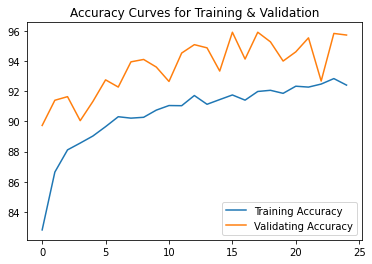

In [0]:

plt.plot(range(0,len(train_accuracy)), train_accuracy, label = "Training Accuracy")
plt.plot(range(0,len(valid_accuracy)), valid_accuracy, label = "Validating Accuracy")
plt.title("Accuracy Curves for Training & Validation")
plt.legend()

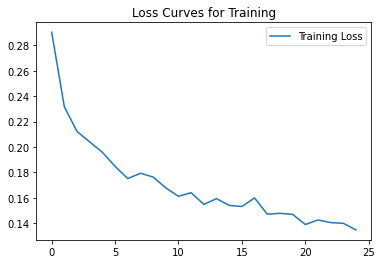

In [0]:
avg_train_loss=[]
for i in train_loss:
  avg_train_loss.append(i/(len(train_data)/32))
plt.plot(range(0,len(train_loss)), avg_train_loss, label = "Training Loss")
plt.title("Loss Curves for Training")
plt.legend()


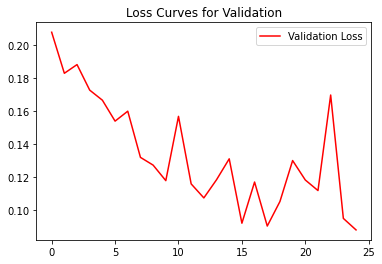

In [0]:
avg_valid_loss=[]
for i in valid_loss:
  avg_valid_loss.append(i/(len(valid_data)/32))
plt.plot(range(0,len(valid_loss)), avg_valid_loss, label = "Validation Loss", color="r")
plt.title("Loss Curves for Validation")
plt.legend()

In [0]:
model_save_name = 'vgg16_test.pth'
model = vgg16
path = F"/content/gdrive/My Drive/MS Data Science 2019-2021/Semester 2/DL/Assignment_5/{model_save_name}" 
torch.save(model.state_dict(), path)

### Training Results

~*Loading Results for Training*~



Precision: 0.9344354838709678
Recall: 0.932741935483871
F1 Score: 0.9335879416448506
Accuracy of the network on the images: 93.002688 %

Confusion Matrices



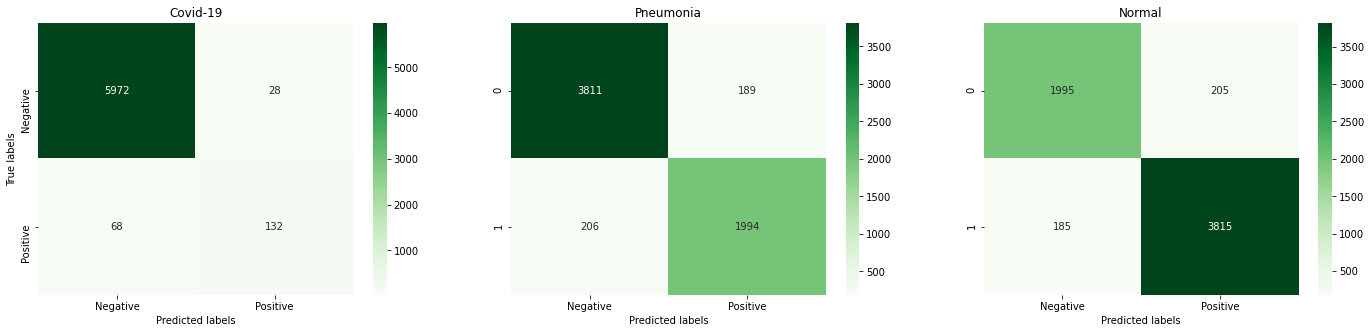

In [182]:
Model_results(vgg16,trainloader,3)

### Validation Results

~*Loading Results for Validation*~



Precision: 0.9609872611464968
Recall: 0.9585987261146497
F1 Score: 0.9597915076071192
Accuracy of the network on the images: 95.727176 %

Confusion Matrices



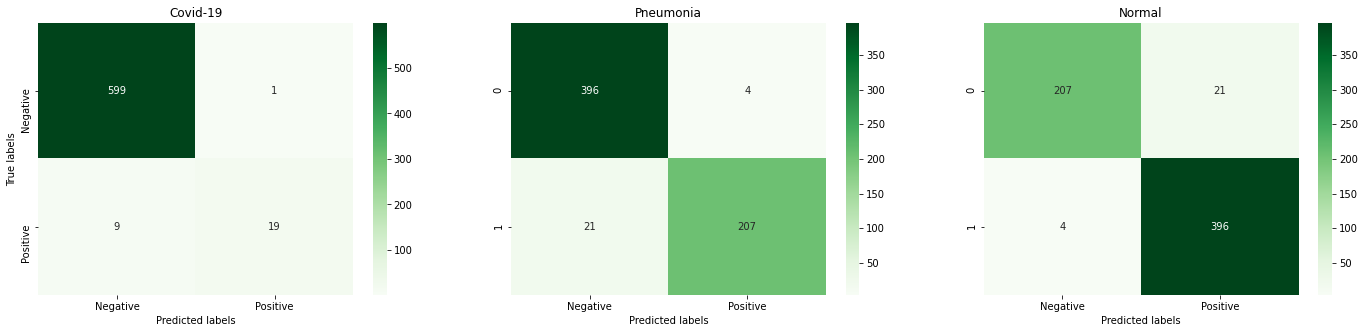

In [183]:
Model_results(vgg16,validloader,3)

### Prediction on Test Data

In [184]:
test_results(testloader)

~*Loading Results for Testing*~



Prediction Completed

Compiling .csv file for results..
csv file saved in directory!
    Image Name  Covid-19  Pneumonia  Normal
0        0.png       0.0        1.0     0.0
1        1.png       0.0        0.0     1.0
2       10.png       0.0        0.0     1.0
3      100.png       0.0        1.0     0.0
4      101.png       0.0        0.0     1.0
..         ...       ...        ...     ...
624     95.png       0.0        1.0     0.0
625     96.png       0.0        0.0     1.0
626     97.png       0.0        0.0     1.0
627     98.png       1.0        1.0     0.0
628     99.png       0.0        0.0     1.0

[629 rows x 4 columns]


## Task1: ResNet-18

### Loading Pretrained Model

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained= True)

### Replacing FC layers

In [161]:
features=[]
num_features = resnet18.fc.in_features
features.extend([nn.Linear(num_features, 250)])
features.extend([nn.Linear(250, len(class_names))])
resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [0]:
Epochs = 20
criterion = nn.BCEWithLogitsLoss()
Sig = nn.Sigmoid()
optimizer = optim.SGD(resnet18.parameters(), lr=0.003, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    acc = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = hot_vec(labels).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
  
        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, targets)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        
        sig_out = Sig(outputs.data)       # Sigmoid
        predicted=torch.round(sig_out)       #0.5 threshold
        
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    train_accuracy.append(100 * acc / len(train_data))
    train_loss.append(running_loss)
    print('Train Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(resnet18.state_dict(), 'resnet18_ft.pth')


    acc = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = hot_vec(labels).to(device)
      
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, targets)   #----> compute loss
        sig_out = Sig(outputs.data)       # Sigmoid
        predicted=torch.round(sig_out)       #0.5 threshold
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        running_loss += loss.item()
        # print statistics
        pbar.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.data))
    valid_accuracy.append(100 * acc / len(valid_data))
    valid_loss.append(running_loss)
    print('Valid Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Train Epoch: 0 [552/6200 (12%)]	Loss: 0.100001: : 194it [01:56,  1.67it/s]

Train Accuracy: 80 %



Valid Epoch: 0 [380/628 (95%)]	Loss: 0.227253: : 20it [00:10,  1.89it/s]

Valid Accuracy: 88 %



Train Epoch: 1 [552/6200 (12%)]	Loss: 0.228347: : 194it [01:56,  1.67it/s]

Train Accuracy: 87 %



Valid Epoch: 1 [380/628 (95%)]	Loss: 0.138603: : 20it [00:10,  1.90it/s]

Valid Accuracy: 90 %



Train Epoch: 2 [552/6200 (12%)]	Loss: 0.426811: : 194it [01:56,  1.66it/s]


Train Accuracy: 88 %


Valid Epoch: 2 [380/628 (95%)]	Loss: 0.117272: : 20it [00:10,  1.87it/s]

Valid Accuracy: 91 %



Train Epoch: 3 [552/6200 (12%)]	Loss: 0.110107: : 194it [01:57,  1.65it/s]


Train Accuracy: 89 %


Valid Epoch: 3 [380/628 (95%)]	Loss: 0.086599: : 20it [00:10,  1.87it/s]

Valid Accuracy: 91 %



Train Epoch: 4 [552/6200 (12%)]	Loss: 0.188240: : 194it [01:58,  1.64it/s]


Train Accuracy: 89 %


Valid Epoch: 4 [380/628 (95%)]	Loss: 0.076527: : 20it [00:10,  1.87it/s]

Valid Accuracy: 91 %



Train Epoch: 5 [552/6200 (12%)]	Loss: 0.105965: : 194it [01:58,  1.64it/s]

Train Accuracy: 89 %



Valid Epoch: 5 [380/628 (95%)]	Loss: 0.164651: : 20it [00:10,  1.87it/s]

Valid Accuracy: 92 %



Train Epoch: 6 [552/6200 (12%)]	Loss: 0.066928: : 194it [01:57,  1.65it/s]

Train Accuracy: 90 %



Valid Epoch: 6 [380/628 (95%)]	Loss: 0.182502: : 20it [00:10,  1.86it/s]

Valid Accuracy: 94 %



Train Epoch: 7 [552/6200 (12%)]	Loss: 0.357794: : 194it [01:58,  1.64it/s]


Train Accuracy: 90 %


Valid Epoch: 7 [380/628 (95%)]	Loss: 0.110432: : 20it [00:10,  1.88it/s]

Valid Accuracy: 92 %



Train Epoch: 8 [552/6200 (12%)]	Loss: 0.111807: : 194it [01:58,  1.64it/s]


Train Accuracy: 91 %


Valid Epoch: 8 [380/628 (95%)]	Loss: 0.118203: : 20it [00:10,  1.88it/s]

Valid Accuracy: 93 %



Train Epoch: 9 [552/6200 (12%)]	Loss: 0.281276: : 194it [01:57,  1.65it/s]

Train Accuracy: 91 %



Valid Epoch: 9 [380/628 (95%)]	Loss: 0.093918: : 20it [00:10,  1.89it/s]

Valid Accuracy: 94 %



Train Epoch: 10 [552/6200 (12%)]	Loss: 0.057051: : 194it [01:56,  1.66it/s]

Train Accuracy: 90 %



Valid Epoch: 10 [380/628 (95%)]	Loss: 0.175306: : 20it [00:10,  1.90it/s]

Valid Accuracy: 94 %



Train Epoch: 11 [552/6200 (12%)]	Loss: 0.120907: : 194it [01:56,  1.66it/s]


Train Accuracy: 91 %


Valid Epoch: 11 [380/628 (95%)]	Loss: 0.056075: : 20it [00:10,  1.90it/s]

Valid Accuracy: 94 %



Train Epoch: 12 [552/6200 (12%)]	Loss: 0.130744: : 194it [01:56,  1.67it/s]


Train Accuracy: 91 %


Valid Epoch: 12 [380/628 (95%)]	Loss: 0.082675: : 20it [00:10,  1.90it/s]

Valid Accuracy: 94 %



Train Epoch: 13 [552/6200 (12%)]	Loss: 0.112948: : 194it [01:57,  1.65it/s]


Train Accuracy: 91 %


Valid Epoch: 13 [380/628 (95%)]	Loss: 0.034951: : 20it [00:10,  1.89it/s]

Valid Accuracy: 95 %



Train Epoch: 14 [552/6200 (12%)]	Loss: 0.104233: : 194it [01:57,  1.65it/s]


Train Accuracy: 91 %


Valid Epoch: 14 [380/628 (95%)]	Loss: 0.153890: : 20it [00:10,  1.89it/s]

Valid Accuracy: 95 %



Train Epoch: 15 [552/6200 (12%)]	Loss: 0.217668: : 194it [01:57,  1.65it/s]


Train Accuracy: 91 %


Valid Epoch: 15 [380/628 (95%)]	Loss: 0.214766: : 20it [00:10,  1.86it/s]

Valid Accuracy: 94 %



Train Epoch: 16 [552/6200 (12%)]	Loss: 0.078849: : 194it [01:57,  1.65it/s]

Train Accuracy: 92 %



Valid Epoch: 16 [380/628 (95%)]	Loss: 0.115587: : 20it [00:10,  1.87it/s]

Valid Accuracy: 95 %



Train Epoch: 17 [552/6200 (12%)]	Loss: 0.057085: : 194it [01:57,  1.65it/s]


Train Accuracy: 92 %


Valid Epoch: 17 [380/628 (95%)]	Loss: 0.189950: : 20it [00:10,  1.89it/s]

Valid Accuracy: 94 %



Train Epoch: 18 [552/6200 (12%)]	Loss: 0.244005: : 194it [01:57,  1.65it/s]


Train Accuracy: 92 %


Valid Epoch: 18 [380/628 (95%)]	Loss: 0.041750: : 20it [00:10,  1.87it/s]

Valid Accuracy: 94 %



Train Epoch: 19 [552/6200 (12%)]	Loss: 0.052611: : 194it [01:55,  1.68it/s]


Train Accuracy: 92 %


Valid Epoch: 19 [380/628 (95%)]	Loss: 0.139810: : 20it [00:10,  1.90it/s]

Valid Accuracy: 95 %
Finished Training


### Plotting Accuracy & Loss

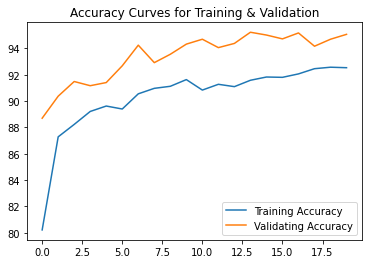

In [0]:
plt.plot(range(0,len(train_accuracy)), train_accuracy, label = "Training Accuracy")
plt.plot(range(0,len(valid_accuracy)), valid_accuracy, label = "Validating Accuracy")
plt.title("Accuracy Curves for Training & Validation")
plt.legend()

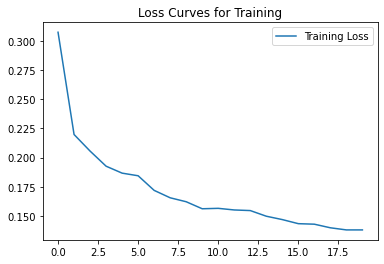

In [0]:
avg_train_loss=[]
for i in train_loss:
  avg_train_loss.append(i/(len(train_data)/32))
plt.plot(range(0,len(train_loss)), avg_train_loss, label = "Training Loss")
plt.title("Loss Curves for Training")
plt.legend()


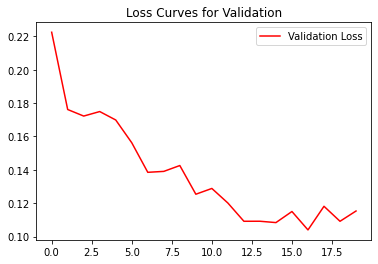

In [0]:
avg_valid_loss=[]
for i in valid_loss:
  avg_valid_loss.append(i/(len(valid_data)/32))
plt.plot(range(0,len(valid_loss)), avg_valid_loss, label = "Validation Loss", color="r")
plt.title("Loss Curves for Validation")
plt.legend()

In [0]:
model_save_name = 'resnet18_test.pth'
model = resnet18
path = F"/content/gdrive/My Drive/MS Data Science 2019-2021/Semester 2/DL/Assignment_5/{model_save_name}" 
torch.save(model.state_dict(), path)

### Training Results

~*Loading Results for Training*~



Precision: 0.9258333333333334
Recall: 0.9270967741935484
F1 Score: 0.926464623017888
Accuracy of the network on the images: 92.411290 %

Confusion Matrices



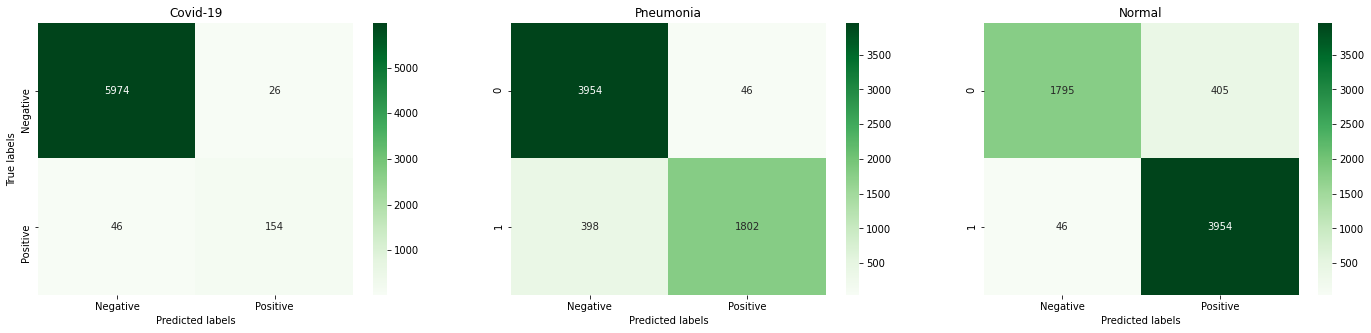

In [169]:
Model_results(resnet18,trainloader,3)

### Validation Results

~*Loading Results for Validation*~



Precision: 0.9522292993630573
Recall: 0.9546178343949044
F1 Score: 0.9534220709280214
Accuracy of the network on the images: 95.090234 %

Confusion Matrices



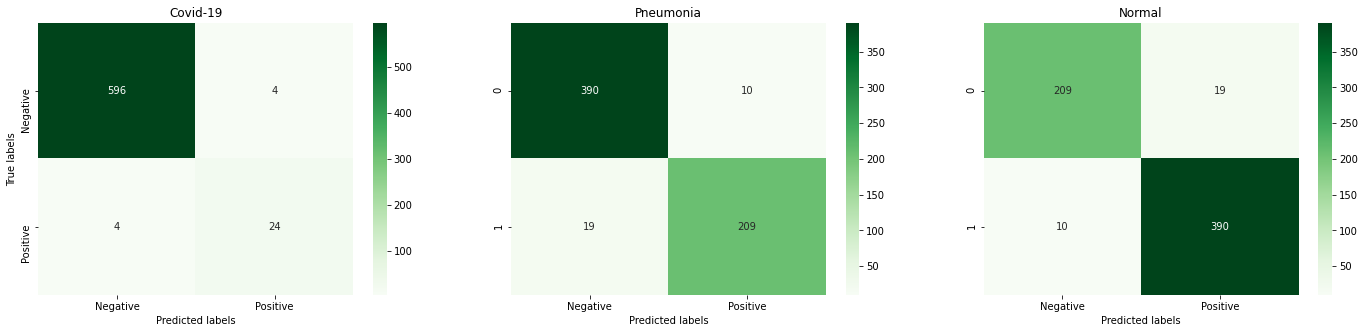

In [168]:
Model_results(resnet18,validloader,3)

### Prediction on Test Data

In [171]:
resnet_test_results(testloader)

~*Loading Results for Testing*~



Prediction Completed

Compiling .csv file for results..
csv file saved in directory!
    Image Name  Covid-19  Pneumonia  Normal
0        0.png       0.0        0.0     1.0
1        1.png       1.0        1.0     0.0
2       10.png       0.0        1.0     0.0
3      100.png       0.0        1.0     0.0
4      101.png       1.0        1.0     0.0
..         ...       ...        ...     ...
624     95.png       0.0        1.0     0.0
625     96.png       0.0        0.0     1.0
626     97.png       0.0        0.0     1.0
627     98.png       0.0        0.0     1.0
628     99.png       0.0        1.0     0.0

[629 rows x 4 columns]


# Task 2: VGG-16 with Focal Loss

### Load pre-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

### Removing FC Layers

In [186]:
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[:0] # Remove last layer
print(features)

[]


### Adding New layers

In [187]:
features.extend([nn.Linear(num_features, 250)])
features.extend([nn.Linear(250, len(class_names))])
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Training

In [0]:
Epochs = 10
Sig = nn.Sigmoid()
optimizer = optim.SGD(vgg16.parameters(), lr=0.004, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    acc = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = hot_vec(labels).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
  
        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = focal_loss(outputs, targets,0.5,2)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        
        sig_out = Sig(outputs.data)       # Sigmoid
        predicted=torch.round(sig_out)       #0.5 threshold
        
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        
        running_loss += loss.item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    train_accuracy.append(100 * acc / len(train_data))
    train_loss.append(running_loss)
    print('Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')


    acc = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = hot_vec(labels).to(device)
        outputs = vgg16(inputs)               #----> forward pass
        loss = focal_loss(outputs, targets,0.5,2)   #----> compute loss
        sig_out = Sig(outputs.data)       # Sigmoid
        predicted=torch.round(sig_out)       #0.5 threshold
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den

        running_loss += loss.item()
    valid_accuracy.append(100 * acc / len(valid_data))
    valid_loss.append(running_loss)
    print('Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Train Epoch: 0 [552/6200 (12%)]	Loss: 0.0151: : 194it [02:03,  1.57it/s]


Accuracy: 92 %


20it [00:09,  2.10it/s]

Accuracy: 93 %



Train Epoch: 1 [552/6200 (12%)]	Loss: 0.0084: : 194it [02:02,  1.58it/s]


Accuracy: 92 %


20it [00:09,  2.06it/s]

Accuracy: 94 %



Train Epoch: 2 [552/6200 (12%)]	Loss: 0.0157: : 194it [02:00,  1.61it/s]


Accuracy: 92 %


20it [00:09,  2.08it/s]

Accuracy: 93 %



Train Epoch: 3 [552/6200 (12%)]	Loss: 0.0398: : 194it [02:00,  1.61it/s]


Accuracy: 92 %


20it [00:09,  2.08it/s]

Accuracy: 94 %



Train Epoch: 4 [552/6200 (12%)]	Loss: 0.0078: : 194it [02:00,  1.61it/s]


Accuracy: 92 %


20it [00:09,  2.14it/s]

Accuracy: 94 %



Train Epoch: 5 [552/6200 (12%)]	Loss: 0.0563: : 194it [01:59,  1.62it/s]


Accuracy: 93 %


20it [00:09,  2.08it/s]

Accuracy: 94 %



Train Epoch: 6 [552/6200 (12%)]	Loss: 0.0193: : 194it [02:00,  1.61it/s]


Accuracy: 92 %


20it [00:09,  2.10it/s]

Accuracy: 94 %



Train Epoch: 7 [552/6200 (12%)]	Loss: 0.0342: : 194it [02:00,  1.61it/s]


Accuracy: 92 %


20it [00:09,  2.06it/s]

Accuracy: 94 %



Train Epoch: 8 [552/6200 (12%)]	Loss: 0.0122: : 194it [01:59,  1.62it/s]


Accuracy: 92 %


20it [00:09,  2.11it/s]

Accuracy: 95 %



Train Epoch: 9 [552/6200 (12%)]	Loss: 0.0517: : 194it [02:00,  1.60it/s]


Accuracy: 92 %


20it [00:09,  2.12it/s]

Accuracy: 95 %
Finished Training


### Plotting Accuracy & Loss

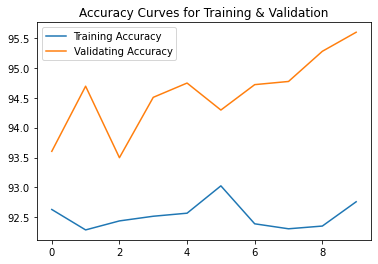

In [0]:
plt.plot(range(0,len(train_accuracy)), train_accuracy, label = "Training Accuracy")
plt.plot(range(0,len(valid_accuracy)), valid_accuracy, label = "Validating Accuracy")
plt.title("Accuracy Curves for Training & Validation")
plt.legend()

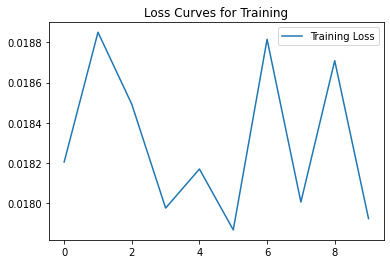

In [0]:
avg_train_loss=[]
for i in train_loss:
  avg_train_loss.append(i/(len(train_data)/32))
plt.plot(range(0,len(train_loss)), avg_train_loss, label = "Training Loss")
plt.title("Loss Curves for Training")
plt.legend()


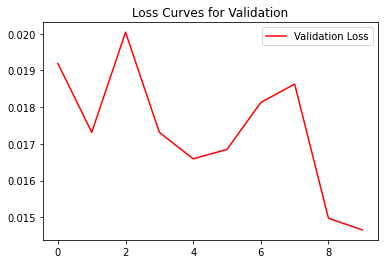

In [0]:
avg_valid_loss=[]
for i in valid_loss:
  avg_valid_loss.append(i/(len(valid_data)/32))
plt.plot(range(0,len(valid_loss)), avg_valid_loss, label = "Validation Loss", color="r")
plt.title("Loss Curves for Validation")
plt.legend()

In [0]:
model_save_name = 'vgg16_focal_loss.pth'
model = vgg16
path = F"/content/gdrive/My Drive/MS Data Science 2019-2021/Semester 2/DL/Assignment_5/{model_save_name}" 
torch.save(model.state_dict(), path)

### Training Results

~*Loading Results for Training*~



Precision: 0.9379838709677419
Recall: 0.9370967741935484
F1 Score: 0.9375401127388209
Accuracy of the network on the images: 93.448925 %

Confusion Matrices



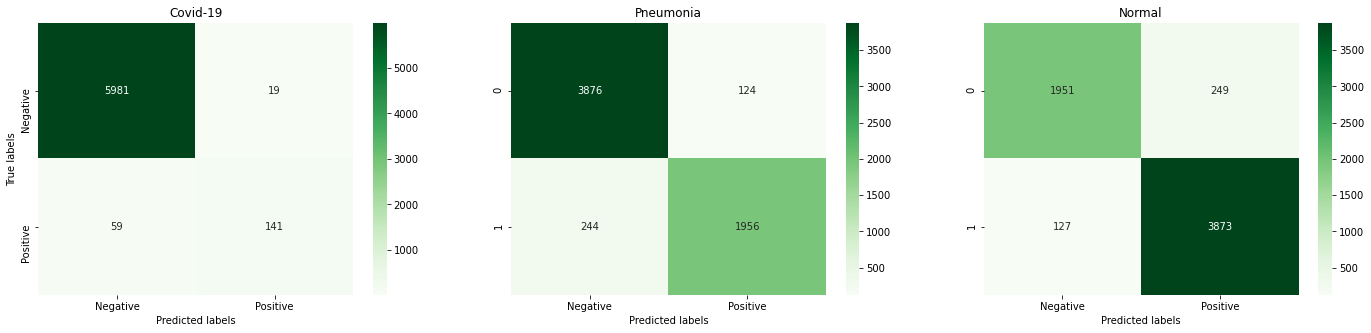

In [0]:
Model_results(vgg16,trainloader,3)

### Validation Results

~*Loading Results for Validation*~



Precision: 0.9593949044585988
Recall: 0.9578025477707006
F1 Score: 0.9585980648369554
Accuracy of the network on the images: 95.594480 %

Confusion Matrices



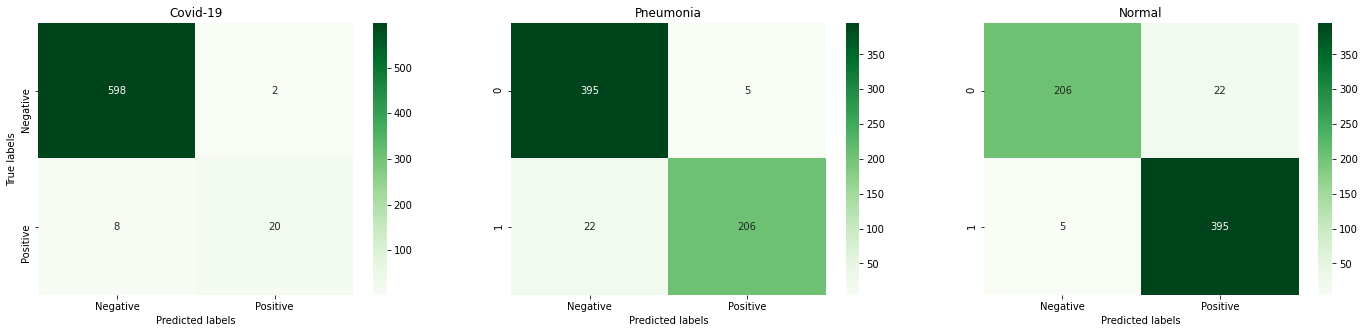

In [192]:
Model_results(vgg16,validloader,3)

In [191]:
test_results

~*Loading Results for Testing*~



Prediction Completed

Compiling .csv file for results..
csv file saved in directory!
    Image Name  Covid-19  Pneumonia  Normal
0        0.png       0.0        1.0     0.0
1        1.png       0.0        0.0     1.0
2       10.png       0.0        0.0     1.0
3      100.png       0.0        1.0     0.0
4      101.png       0.0        0.0     1.0
..         ...       ...        ...     ...
624     95.png       1.0        1.0     0.0
625     96.png       0.0        0.0     1.0
626     97.png       0.0        0.0     1.0
627     98.png       0.0        0.0     1.0
628     99.png       0.0        0.0     1.0

[629 rows x 4 columns]


## Task2: ResNet-18 with Focal Loss

### Loading Pretrained Model

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained= True)

### Replacing FC layers

In [16]:
features=[]
num_features = resnet18.fc.in_features
features.extend([nn.Linear(num_features, 250)])
features.extend([nn.Linear(250, len(class_names))])
resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [0]:
Epochs = 20
Sig = nn.Sigmoid()
optimizer = optim.SGD(resnet18.parameters(), lr=0.003, momentum=0.9)

In [18]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
train_accuracy = []
train_loss = []
valid_accuracy = []
valid_loss = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    acc = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = hot_vec(labels).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
  
        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = focal_loss(outputs, targets,0.25,2)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        
        sig_out = Sig(outputs.data)       # Sigmoid
        predicted=torch.round(sig_out)       #0.5 threshold
        
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    train_accuracy.append(100 * acc / len(train_data))
    train_loss.append(running_loss)
    print('Train Accuracy: %d %%' % (train_accuracy[-1]))
    torch.save(resnet18.state_dict(), 'resnet18_ft.pth')


    acc = 0
    total = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(validloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        targets = hot_vec(labels).to(device)
      
        outputs = resnet18(inputs)               #----> forward pass
        loss = focal_loss(outputs, targets,0.25,2)   #----> compute loss
        sig_out = Sig(outputs.data)       # Sigmoid
        predicted=torch.round(sig_out)       #0.5 threshold
        for i in range(len(labels)):
          num=(predicted[i]*targets[i]).sum().item()
          den=(predicted[i].logical_or_(targets[i])).sum().item()
          acc+=num/den
        running_loss += loss.item()
        # print statistics
        pbar.set_description(
            'Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, i * len(inputs), len(validloader.dataset),
                100. * i / len(validloader),
                loss.data))
    valid_accuracy.append(100 * acc / len(valid_data))
    valid_loss.append(running_loss)
    print('Valid Accuracy: %d %%' % (valid_accuracy[-1]))
print('Finished Training')

Train Epoch: 0 [552/6200 (12%)]	Loss: 0.0241: : 194it [01:53,  1.71it/s]

Train Accuracy: 68 %



Valid Epoch: 0 [380/628 (95%)]	Loss: 0.0220: : 20it [00:09,  2.15it/s]

Valid Accuracy: 80 %



Train Epoch: 1 [552/6200 (12%)]	Loss: 0.0144: : 194it [01:50,  1.76it/s]


Train Accuracy: 81 %


Valid Epoch: 1 [380/628 (95%)]	Loss: 0.0239: : 20it [00:09,  2.19it/s]

Valid Accuracy: 82 %



Train Epoch: 2 [552/6200 (12%)]	Loss: 0.0243: : 194it [01:49,  1.78it/s]

Train Accuracy: 84 %



Valid Epoch: 2 [380/628 (95%)]	Loss: 0.0220: : 20it [00:09,  2.15it/s]

Valid Accuracy: 85 %



Train Epoch: 3 [552/6200 (12%)]	Loss: 0.0196: : 194it [01:49,  1.78it/s]


Train Accuracy: 84 %


Valid Epoch: 3 [380/628 (95%)]	Loss: 0.0166: : 20it [00:09,  2.22it/s]

Valid Accuracy: 86 %



Train Epoch: 4 [552/6200 (12%)]	Loss: 0.0140: : 194it [01:48,  1.80it/s]


Train Accuracy: 85 %


Valid Epoch: 4 [380/628 (95%)]	Loss: 0.0127: : 20it [00:09,  2.22it/s]

Valid Accuracy: 86 %



Train Epoch: 5 [552/6200 (12%)]	Loss: 0.0135: : 194it [01:48,  1.79it/s]


Train Accuracy: 86 %


Valid Epoch: 5 [380/628 (95%)]	Loss: 0.0064: : 20it [00:09,  2.22it/s]

Valid Accuracy: 86 %



Train Epoch: 6 [552/6200 (12%)]	Loss: 0.0235: : 194it [01:47,  1.80it/s]


Train Accuracy: 87 %


Valid Epoch: 6 [380/628 (95%)]	Loss: 0.0178: : 20it [00:08,  2.24it/s]

Valid Accuracy: 89 %



Train Epoch: 7 [552/6200 (12%)]	Loss: 0.0198: : 194it [01:47,  1.80it/s]


Train Accuracy: 87 %


Valid Epoch: 7 [380/628 (95%)]	Loss: 0.0154: : 20it [00:08,  2.24it/s]

Valid Accuracy: 88 %



Train Epoch: 8 [552/6200 (12%)]	Loss: 0.0094: : 194it [01:47,  1.81it/s]


Train Accuracy: 87 %


Valid Epoch: 8 [380/628 (95%)]	Loss: 0.0102: : 20it [00:09,  2.18it/s]

Valid Accuracy: 88 %



Train Epoch: 9 [552/6200 (12%)]	Loss: 0.0140: : 194it [01:49,  1.78it/s]


Train Accuracy: 88 %


Valid Epoch: 9 [380/628 (95%)]	Loss: 0.0278: : 20it [00:09,  2.18it/s]

Valid Accuracy: 87 %



Train Epoch: 10 [552/6200 (12%)]	Loss: 0.0202: : 194it [01:50,  1.76it/s]


Train Accuracy: 88 %


Valid Epoch: 10 [380/628 (95%)]	Loss: 0.0109: : 20it [00:09,  2.16it/s]

Valid Accuracy: 89 %



Train Epoch: 11 [552/6200 (12%)]	Loss: 0.0089: : 194it [01:50,  1.76it/s]

Train Accuracy: 88 %



Valid Epoch: 11 [380/628 (95%)]	Loss: 0.0225: : 20it [00:09,  2.18it/s]

Valid Accuracy: 89 %



Train Epoch: 12 [552/6200 (12%)]	Loss: 0.0099: : 194it [01:48,  1.78it/s]

Train Accuracy: 88 %



Valid Epoch: 12 [380/628 (95%)]	Loss: 0.0240: : 20it [00:09,  2.20it/s]

Valid Accuracy: 89 %



Train Epoch: 13 [552/6200 (12%)]	Loss: 0.0136: : 194it [01:47,  1.80it/s]


Train Accuracy: 88 %


Valid Epoch: 13 [380/628 (95%)]	Loss: 0.0200: : 20it [00:09,  2.21it/s]

Valid Accuracy: 89 %



Train Epoch: 14 [552/6200 (12%)]	Loss: 0.0185: : 194it [01:48,  1.79it/s]


Train Accuracy: 89 %


Valid Epoch: 14 [380/628 (95%)]	Loss: 0.0146: : 20it [00:08,  2.22it/s]

Valid Accuracy: 90 %



Train Epoch: 15 [552/6200 (12%)]	Loss: 0.0082: : 194it [01:47,  1.81it/s]


Train Accuracy: 88 %


Valid Epoch: 15 [380/628 (95%)]	Loss: 0.0226: : 20it [00:08,  2.23it/s]

Valid Accuracy: 90 %



Train Epoch: 16 [552/6200 (12%)]	Loss: 0.0124: : 194it [01:47,  1.80it/s]


Train Accuracy: 88 %


Valid Epoch: 16 [380/628 (95%)]	Loss: 0.0178: : 20it [00:08,  2.25it/s]

Valid Accuracy: 91 %



Train Epoch: 17 [552/6200 (12%)]	Loss: 0.0203: : 194it [01:47,  1.81it/s]

Train Accuracy: 89 %



Valid Epoch: 17 [380/628 (95%)]	Loss: 0.0043: : 20it [00:08,  2.23it/s]

Valid Accuracy: 90 %



Train Epoch: 18 [552/6200 (12%)]	Loss: 0.0122: : 194it [01:47,  1.80it/s]


Train Accuracy: 89 %


Valid Epoch: 18 [380/628 (95%)]	Loss: 0.0146: : 20it [00:09,  2.22it/s]

Valid Accuracy: 90 %



Train Epoch: 19 [552/6200 (12%)]	Loss: 0.0131: : 194it [01:47,  1.81it/s]

Train Accuracy: 89 %



Valid Epoch: 19 [380/628 (95%)]	Loss: 0.0408: : 20it [00:08,  2.25it/s]

Valid Accuracy: 89 %
Finished Training


### Plotting Accuracy & Loss

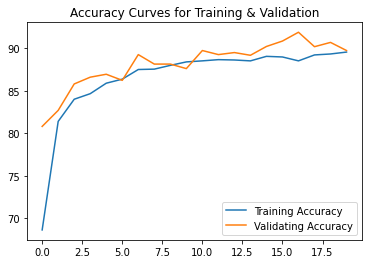

In [19]:
plt.plot(range(0,len(train_accuracy)), train_accuracy, label = "Training Accuracy")
plt.plot(range(0,len(valid_accuracy)), valid_accuracy, label = "Validating Accuracy")
plt.title("Accuracy Curves for Training & Validation")
plt.legend()

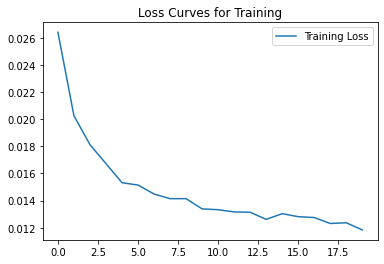

In [20]:
avg_train_loss=[]
for i in train_loss:
  avg_train_loss.append(i/(len(train_data)/32))
plt.plot(range(0,len(train_loss)), avg_train_loss, label = "Training Loss")
plt.title("Loss Curves for Training")
plt.legend()


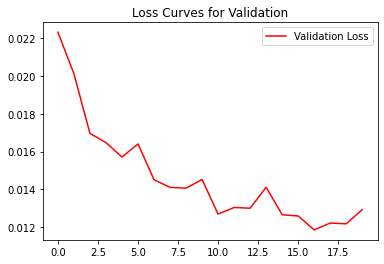

In [21]:
avg_valid_loss=[]
for i in valid_loss:
  avg_valid_loss.append(i/(len(valid_data)/32))
plt.plot(range(0,len(valid_loss)), avg_valid_loss, label = "Validation Loss", color="r")
plt.title("Loss Curves for Validation")
plt.legend()

### Training Results

~*Loading Results for Training*~



Precision: 0.8996774193548387
Recall: 0.8951612903225806
F1 Score: 0.8974136731522924
Accuracy of the network on the images: 89.139785 %

Confusion Matrices



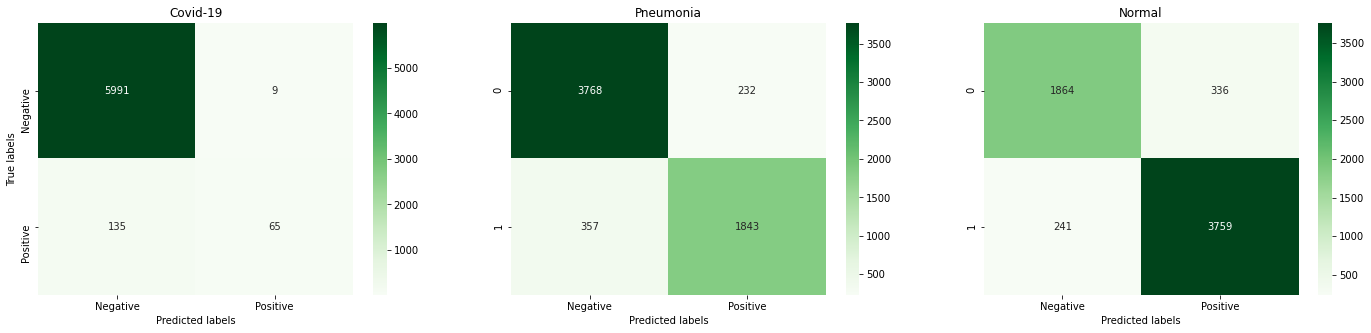

In [23]:
Model_results(resnet18,trainloader,3)

### Validation Results

~*Loading Results for Validation*~



Precision: 0.910828025477707
Recall: 0.9076433121019108
F1 Score: 0.9092328800740683
Accuracy of the network on the images: 90.445860 %

Confusion Matrices



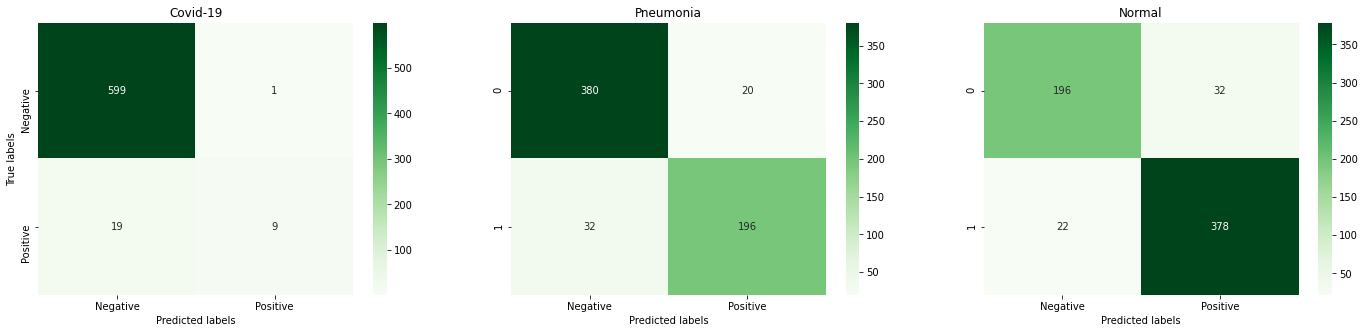

In [22]:
Model_results(resnet18,validloader,3)

In [0]:
model_save_name = 'res18_focal_loss.pth'
model = resnet18
path = F"/content/gdrive/My Drive/MS Data Science 2019-2021/Semester 2/DL/Assignment_5/{model_save_name}" 
torch.save(model.state_dict(), path)